# PYNAMESTATE

this is a engine to convert data from the SSI name index into a format suitable for clustering states and years on the basis of how similar names were from state to state and year to year.  Notebook assumes you're loading from an enviroment with python3, numpy, pandas, matplotlib, and scikit. 

data used here downloaded from: https://www.ssa.gov/OACT/babynames/state/namesbystate.zip

#### existing code does the following: 
- loads data from raw .csv into dataframe (converted from .txt in ssi zip)
- concatinates dataframes from each file into a larger dataframe
- imputes missing names (it'd be nice to have all names per year per state per gender to make something nice and matrix-y later on)
- calculates a score based on the fraction of births/year with a given name
- calculates similarity between states and years based on name freqency
- reduces the number of observed variables (i.e. names) via PCA
- clusters states in a given year based on similarity
- displays heatmap and scatter of clustering

## data importing

In [474]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import warnings
import ipywidgets as widgets
from IPython.display import display
warnings.filterwarnings('ignore')

# assuming you're running the notebook where the data is
#os.chdir('namesbystate')
cwd = os.getcwd()

# find all the *.csv files locally and put them into a list (os.path.join)
# and do it with 'nix naming conventions (glob.glob)
all_files = glob.glob(os.path.join(cwd, "*.csv"))    

# read each file in all_files into a dataframe with proper headers, and concatinate to larger dataframe
df = pd.concat(pd.read_csv(f, names = ["state", "gender", "year", "name", "nbirths"]) for f in all_files)

# display the result, see if it looks like the dataframe we want
print(df[0:2])



  state gender  year   name  nbirths
0    AK      F  1910   Mary     14.0
1    AK      F  1910  Annie     12.0


## preprocessing: shrink data

In [450]:
# drop the boys
df = df[df.gender !='M']
df = df.drop('gender',1)

# take names with reasonable frequency
#df = df[df.nbirths>20]

# take a small subset of years
# aids in fitting in system memory
firstyear=1945
years = range(firstyear,2011,150)
df = df.loc[df['year'].isin(years)]

print(df[0:2])


    state  year      name  nbirths
919    AK  1945      Mary     47.0
920    AK  1945  Patricia     21.0


## preprocessing: impute missing values

In [451]:
# to end with a 50 x n_names matrix of similarity to classify on
# it'd be nice to fill in birth #'s for missing names (for that year,state)
# this is not particularly fast, roughly 5 minutes per year - slower if we're more inclusive with rare names

# first, deliniate how the dataframe is structured
%time level_index = ['state','year','name']

# then establish how a full (n_states x n_years x n_names) dataframe would be structured
%time full_index = pd.MultiIndex.from_product([df[col].unique() for col in level_index], names=level_index)

#then, re-index first dataframe in the larger, fully indexed dataframe
%time df = df.set_index(level_index).reindex(full_index)
%time df = df.reset_index()
%time df = df.sort_values(['year','state','name'], ascending = True)


# now, the dataframe should include 'new' names for each year, state
%time print(df[0:2])

Wall time: 0 ns
Wall time: 1e+03 µs
Wall time: 246 ms
Wall time: 7 ms
Wall time: 51.8 ms
     state  year     name  nbirths
1492    AK  1945     Abby      NaN
987     AK  1945  Abigail      NaN
Wall time: 0 ns


## analysis: create feature to classify by

In [452]:
# let's calculate the measure by which we'll look at state, year similarity

# find the number of births that year, and calculate a ratio based on nbirths/totalbirths
df['nbirthsum'] = df.groupby(["state","year"])["nbirths"].transform(np.nansum)
df['nbirthratio'] = df["nbirths"]/df["nbirthsum"]

# now with the addition of our nbirthratio
print(df[0:5])

# we can access the values we want through the following logical indexing, for reference: 
print(df[(df.state == "MA") & (df.year == 1985) & (df.name == "Mary")]["nbirthratio"].values)
print(df.size)

     state  year     name  nbirths  nbirthsum  nbirthratio
1492    AK  1945     Abby      NaN      447.0          NaN
987     AK  1945  Abigail      NaN      447.0          NaN
223     AK  1945      Ada      NaN      447.0          NaN
238     AK  1945    Addie      NaN      447.0          NaN
603     AK  1945    Adela      NaN      447.0          NaN
[]
575892


## analysis: transform data into workable matrix 

In [453]:
# let's format the new nbirthratio into a state by name matrix for a given year (np.array)

import numpy as np

# first find the dimensions
state_index = df.state.unique()
name_index = df.name.unique()


# then, initialize the matrix
df_matrix = np.zeros((len(state_index), len(name_index)))

# then, let's populate the larger matrix
# note: this is SLOW (50ms per element!, 2h total)

for st in range(0, len(state_index)): 
    
    df_matrix[st, :] = df[(df.state == state_index[st]) & (df.year == firstyear)]["nbirthratio"].values
    

df_matrix[np.isnan(df_matrix)]=0

print(df_matrix[1:5,1:5])

[[  0.00000000e+00   8.32506164e-04   6.72408825e-04   0.00000000e+00]
 [  0.00000000e+00   8.19000819e-04   7.09800710e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.15245308e-03]
 [  7.18511245e-05   1.79627811e-04   0.00000000e+00   2.27528561e-04]]


## exloration: how similar are names for each state?

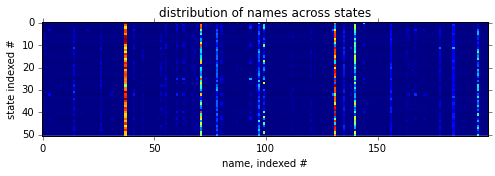

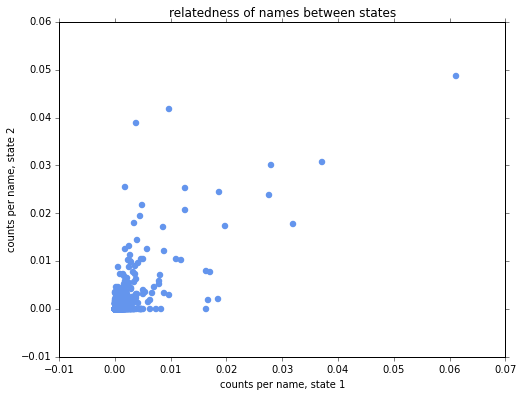

In [454]:
# make figures nicer by plotting inline
# and making those inline figures bigger

%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (8.0, 6.0)


## OK, so now that we have our matrix, let's 
## visualize the relatedness among states


# make a plot of name frequency across states
# showing modest differences, and broad correlations

from sklearn.preprocessing import scale


x = range(100,300)
#y=np.log10(df_matrix[:,x].T)
y = scale(df_matrix[:,x],axis=1)
#y = y[~np.isinf(y)]
#y.shape = (50, np.size(y)/50)

plt.imshow(y,interpolation='none')
plt.xlabel('name, indexed #')
plt.ylabel('state indexed #')
plt.title('distribution of names across states')

ax = plt.gca()
ax.tick_params(direction='out')
#ax.stackplot(range(1,1500),[df_matrix[ii,1:1500].T for ii in range(0,50)])




plt.show()
# make a scatter of two arbitrary states to show strong, but imperfect correlation

plt.scatter(df_matrix[10,:],df_matrix[41,:], color = 'cornflowerblue', linewidth = 2)
plt.xlabel('counts per name, state 1')
plt.ylabel('counts per name, state 2')
plt.title('relatedness of names between states')
ax = plt.gca()
ax.tick_params(direction='out')


plt.show()


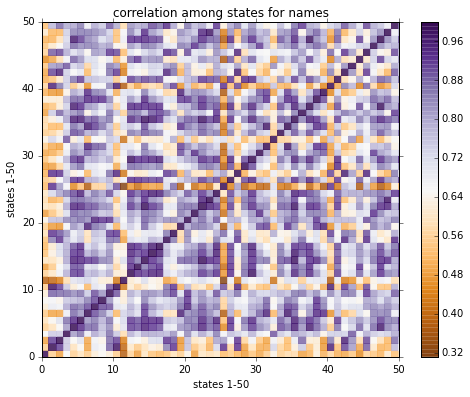

In [455]:
# let's see if all the states are the same - here we're ordered alphabetically

# calculate raw, un-normalized correlation coefficients 
# between each pair of states - normalization lowers correlation drastically

raw_state_corr=np.corrcoef(df_matrix)


# make a simple heatmap of states, ordered alphabetically

plt.pcolor(np.power(raw_state_corr,2), cmap=plt.cm.PuOr, alpha=0.8)

plt.colorbar()
plt.xlabel('states 1-50')
plt.ylabel('states 1-50')
plt.xlim([0, 50]), plt.ylim([0, 50])
plt.title('correlation among states for names')
ax = plt.gca()
ax.tick_params(direction='out')

plt.show()

## exploration: does sorting by name similarity cluster states in a meaningful way? 


MiniBatchKMeans
['CA' 'CO' 'HI' 'IA' 'ID' 'IL' 'IN' 'KS' 'ME' 'MI' 'MN' 'MO' 'MT' 'ND' 'NE'
 'NV' 'OH' 'OK' 'OR' 'SD' 'UT' 'WA' 'WV' 'WY']
['AL' 'AR' 'AZ' 'FL' 'GA' 'KY' 'LA' 'MS' 'NC' 'NM' 'SC' 'TN' 'TX' 'VA']
['AK' 'CT' 'DC' 'DE' 'MA' 'MD' 'NH' 'NJ' 'NY' 'PA' 'RI' 'VT' 'WI']


AffinityPropagation
['CA' 'CO' 'IA' 'ID' 'IN' 'KS' 'ME' 'MI' 'MO' 'MT' 'ND' 'NE' 'NV' 'OH' 'OK'
 'OR' 'SD' 'UT' 'WA' 'WY']
['AK' 'CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'MN' 'NH' 'NJ' 'NY' 'PA' 'RI' 'VT'
 'WI']
['AL' 'AR' 'AZ' 'FL' 'GA' 'KY' 'LA' 'MS' 'NC' 'NM' 'SC' 'TN' 'TX' 'VA' 'WV']


MeanShift
['CA' 'CO' 'IA' 'ID' 'IN' 'KS' 'MO' 'MT' 'ND' 'NE' 'NV' 'OH' 'OK' 'OR' 'SD'
 'UT' 'WA' 'WY']
['CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'ME' 'MI' 'MN' 'NH' 'NJ' 'NY' 'PA' 'RI'
 'VT' 'WI']
['AL' 'AR' 'AZ' 'FL' 'GA' 'KY' 'LA' 'MS' 'NC' 'NM' 'SC' 'TN' 'TX' 'VA' 'WV']


SpectralClustering
['AL' 'AR' 'AZ' 'FL' 'GA' 'KY' 'LA' 'MS' 'NC' 'NM' 'SC' 'TN' 'TX' 'VA' 'WV']
['CA' 'CO' 'IA' 'ID' 'IN' 'KS' 'MO' 'MT' 'ND' 'NE' 'NV' 'OH' 'OK' 'O

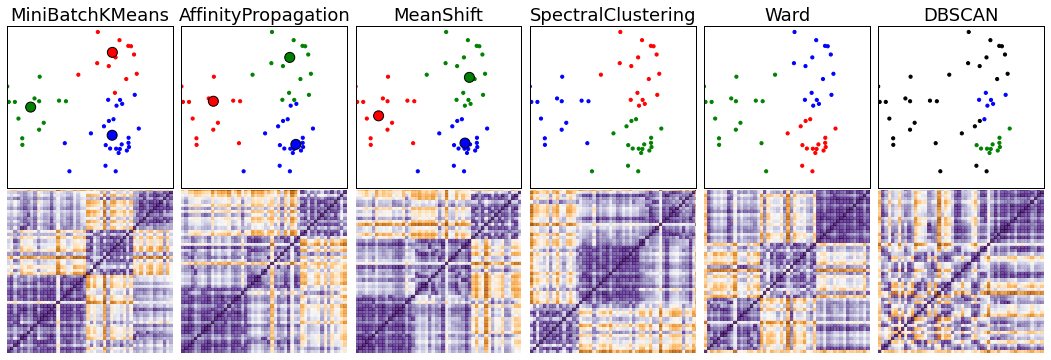

In [456]:

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times

pca = PCA(n_components=2)
pca.fit(df_matrix)
X = pca.transform(df_matrix)
dataset = (X, np.zeros(np.size(X)))


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward',
    'DBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
clus_num = 3

datasets = [dataset]

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.2)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=20, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    two_means = cluster.MiniBatchKMeans(n_clusters=clus_num)
    
    ward = cluster.AgglomerativeClustering(n_clusters=clus_num, linkage='ward')
                                         #  connectivity=connectivity)
    
    spectral = cluster.SpectralClustering(n_clusters=clus_num,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    
    dbscan = cluster.DBSCAN(eps=.4)
    
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-20)

    birch = cluster.Birch(n_clusters=clus_num)
    
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, 
        dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
            cluster_order = np.argsort(algorithm.labels_)
            sort_state_corr = np.power(raw_state_corr[cluster_order,:],1)
            # let's list the groups for validation
            print()
            print(name)
            print(state_index[algorithm.labels_ == 0])
            print(state_index[algorithm.labels_ == 1])
            print(state_index[algorithm.labels_ == 2])

            print()



        else:
            y_pred = algorithm.predict(X)
            cluster_order = np.argsort(y_pred)
            sort_state_corr = np.power(raw_state_corr[cluster_order,:],1)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        
        
        plt.subplot(4, len(clustering_algorithms), plot_num+len(clustering_algorithms))
        plt.pcolor(np.power(sort_state_corr[:,cluster_order],2), cmap=plt.cm.PuOr, alpha=0.8)
        plt.xticks(())
        plt.yticks(())
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.box(on=None)


        plot_num += 1

plt.show()

In [488]:
## LETS TAKE A CLOSER LOOK AT ONE OF THE ALGORITHMS
## in a slightly higher dimensional space
## and see which state corresponds to each of these points..

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pca = PCA(n_components=50)
pca.fit(df_matrix)
X = pca.transform(df_matrix)

for linkage in ('ward', ):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    model.fit(X[:,0:4])
    

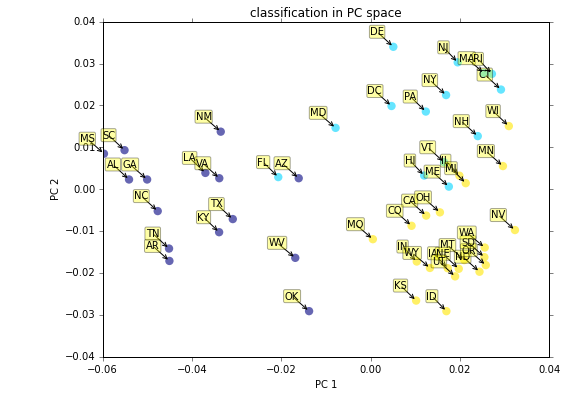

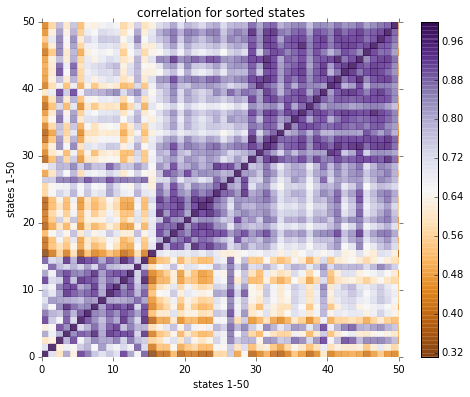

In [489]:
# and plot the results nicely, please.
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=70, alpha = 0.6, edgecolor = 'None')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim([-0.06, 0.04])
plt.ylim([-0.04, 0.04])
plt.title('classification in PC space')


# add state name labels to the scatterplot of choice
for label, x, y in zip(state_index, X[:, 0], X[:, 1]):
  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.15', fc='yellow', alpha=0.35),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax = plt.gca()
ax.tick_params(direction='out')
plt.show()


#plt.subplot(1,2,2)

cluster_order=np.argsort(model.labels_)
psort_state_corr=np.power(raw_state_corr[:,cluster_order],2)
sort_state_corr=np.power(raw_state_corr[cluster_order,:],1)

plt.pcolor(np.power(sort_state_corr[:,cluster_order],2), cmap=plt.cm.PuOr, alpha=0.8)
plt.colorbar()

plt.xlabel('states 1-50')
plt.ylabel('states 1-50')
plt.xlim([0, 50]), plt.ylim([0, 50])
plt.box(on=None)
plt.title('correlation for sorted states')
ax = plt.gca()
ax.tick_params(direction='out')
plt.show()

In [490]:
# and what groups are these? 
def printgroup(x):
    # let's list the groups 
    print(state_index[model.labels_ == x])

widgets.interact(printgroup, x=(0, 3, 1))


['AK']


## exploration: can we tell where someone is from by their first name? 

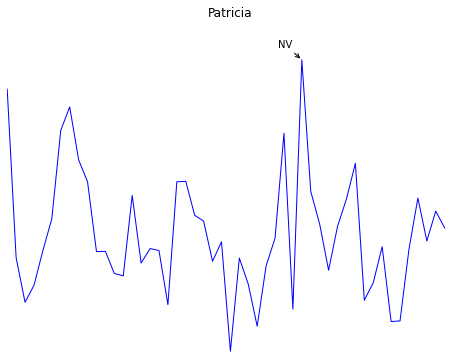

In [475]:
# so - what about for indivdual names?  can we guess where someone's from by their name? 

common_names = name_index[np.argsort(np.sum(df_matrix,axis=0))]
common_names = common_names[-40:-1].tolist()

def plotname(x):
 

    plt.plot(df_matrix[0:50,name_index==x])
    label =state_index[np.argmax(df_matrix[0:50,name_index==x])]
    plt.xticks(())
    plt.yticks(())
    plt.box(on=None)

    x1 = np.argmax(df_matrix[0:50,name_index==x])
    y1 = np.max(df_matrix[0:50,name_index==x])

    plt.annotate(
        label,
        xy=(x1, y1), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.title(x)
    plt.show()
    
widgets.interact(plotname, x=common_names)

# seems like an intersting basis for a model: guess where and when you're born
# simply on the basis of your first name!